<a href="https://colab.research.google.com/github/daniel-mcdermott/PHY571-Brazil/blob/main/BrazilNuts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-79f8c9a97968>:177: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_disk.set_data(disk.position[0], disk.position[1])


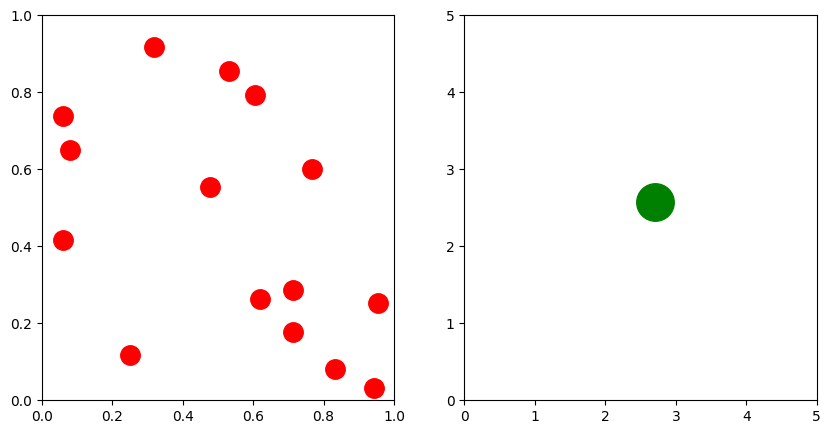

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class Disks:
    """A class describing many disks in a box"""

    def __init__(self, n_disks, radius=0.01):
        """Create randomly several disks"""

        self.n_disks = n_disks
        self.radius = radius
        self.positions = np.random.random([n_disks, 2]) * (1 - 2 * radius) + radius
        self.velocities = np.random.random([n_disks, 2]) * 2 - 1.
        self.events = np.zeros([n_disks, 4 + n_disks]) * np.nan
        self.walls = np.array([1., 1., 0., 0.])

        for i in range(n_disks):
            self.update_events(i)

    def update_events(self, p):
        """Update the events for the p^th disk"""

        pos = self.positions[p, :]
        vel = self.velocities[p, :]
        walls = self.walls
        r = self.radius

        # no self-collision!
        self.events[p, p] = np.nan

        # collisions with a wall
        for i in range(4):
            s = 1 if i < 2 else -1
            if s * vel[i % 2] > 0:
                self.events[p, i] = (walls[i] - pos[i % 2] - s * r) / vel[i % 2]
            else:
                self.events[p, i] = np.nan

        # collisions with other disks
        for i in range(self.n_disks):
            if i != p:
                t = self._time_to_collision(p, i)
                self.events[p, i + 4] = t
                self.events[i, p + 4] = t

    def step(self, dt):
        """Make a time step dt"""

        # find event with the smallest time
        ind = np.unravel_index(np.nanargmin(self.events), self.events.shape)
        t_coll = self.events[ind]

        if dt < t_coll:
            self.positions += self.velocities * dt
            self.events -= dt
        else:
            self.positions += self.velocities * t_coll
            self.events -= t_coll
            self._new_velocities(ind)
            self.step(dt - t_coll)

    def _time_to_collision(self, p1, p2):
        """Helper method to find disk-disk collision time"""

        sigma = 2 * self.radius
        delta_v = self.velocities[p2, :] - self.velocities[p1, :]
        delta_r = self.positions[p2, :] - self.positions[p1, :]
        dvdr = np.dot(delta_v, delta_r)

        if dvdr > 0:
            return np.nan

        dvdv = np.dot(delta_v, delta_v)
        d = dvdr**2 - dvdv * (np.dot(delta_r, delta_r) - sigma**2)

        if d < 0:
            return np.nan

        return -(dvdr + np.sqrt(d)) / dvdv

    def _new_velocities(self, ind):

        p1 = ind[0]

        # Event was a collision with a wall
        if ind[1] < 4:
            self.velocities[p1, ind[1] % 2] = -self.velocities[p1, ind[1] % 2]
            self.update_events(p1)

        # Event was a collision with another disk
        else:
            p2 = ind[1] - 4
            sigma = 2 * self.radius
            delta_v = self.velocities[p2, :] - self.velocities[p1, :]
            delta_r = self.positions[p2, :] - self.positions[p1, :]
            dvdr = np.dot(delta_v, delta_r)
            imp = 2 * 1 * 1 * dvdr / (sigma * (1 + 1))
            imp_v = imp * delta_r / sigma

            self.velocities[p1, :] += imp_v
            self.velocities[p2, :] -= imp_v
            self.update_events(p1)
            self.update_events(p2)


class SingleDisk:
    """A class for the evolution of a pinball disk in a box"""

    def __init__(self, r, lx, ly, pos, vel):
        """Create a disk in a box"""
        self.radius = r
        self.position = pos
        self.velocity = vel
        self.wall = np.array([0, 0, lx, ly])  # to compare for events at L, B, R, T walls
        self.events = np.zeros(4)
        self.update_events_table()

    def update_events_table(self):
        """Update the elements of the events table"""
        if self.velocity[0] > 0:
            self.events[0] = np.nan
            self.events[2] = (self.wall[2] - self.position[0] - self.radius) / self.velocity[0]
        elif self.velocity[0] < 0:
            self.events[2] = np.nan
            self.events[0] = (self.wall[0] - self.position[0] + self.radius) / self.velocity[0]
        if self.velocity[1] > 0:
            self.events[1] = np.nan
            self.events[3] = (self.wall[3] - self.position[1] - self.radius) / self.velocity[1]
        elif self.velocity[1] < 0:
            self.events[3] = np.nan
            self.events[1] = (self.wall[1] - self.position[1] + self.radius) / self.velocity[1]

    def step(self, dt):
        """Evolve disk to the next event and update events table"""
        first = np.nanargmin(self.events)
        t_coll = self.events[first]

        if dt < t_coll:
            self.position += dt * self.velocity
            self.events -= dt
        else:
            self.position += t_coll * self.velocity
            self.velocity[first % 2] = -self.velocity[first % 2]
            self.update_events_table()
            self.step(dt - t_coll)

        self.update_events_table()


# Test the classes

# Create Disks object
disks = Disks(15, 0.02)

# Create SingleDisk object
pos = np.array([2.5, 2.5])
vel = np.array([1., 0.4])
disk = SingleDisk(0.3, 5., 5., pos, vel)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)

line_disks, = axs[0].plot([], [], 'ro', ms=14)
line_disk, = axs[1].plot([], [], 'go', ms=27)


def animate(i):
    disks.step(0.01)
    line_disks.set_data(disks.positions[:, 0], disks.positions[:, 1])

    disk.step(0.1)
    line_disk.set_data(disk.position[0], disk.position[1])

    return line_disks, line_disk


anim = animation.FuncAnimation(fig, animate, interval=10, blit=True, frames=500, repeat=False)
plt.show()






